Dataset: https://www.kaggle.com/datasets/tongpython/cat-and-dog

## Requirements:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [2]:
# LeNet was created by AT&T, named after Yann LeCun
# Image size is resized to 32x32, as per CIFAR10 size
# The first linear layer must be sized based on the size of the kernels, and the size of the images used to train/test after resizing

class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 3 input image channel, 6 output feature maps and 5x5 conv kernel
        self.cn1 = nn.Conv2d(3, 6, 5) # (32-5+0)/1 + 1 => 28 * 28 * 6
        self.maxpool1 = nn.MaxPool2d(2)
        # After pooling, 28/2 => 14 * 14 * 6
        # 6 input image channel, 16 output feature maps and 5x5 conv kernel
        self.cn2 = nn.Conv2d(6, 16, 5) # (14-5+0)/1 + 1 = 10 * 10 * 16
        self.maxpool2 = nn.MaxPool2d(2)
        # fully connected layers of size 120, 84 and 10
        # After pooling, 10/2 => 5 * 5 * 16
        self.flatten1 = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 is the spatial dimension at this layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Convolution with 5x5 kernel
        x = F.relu(self.cn1(x))
        # Max pooling over a (2, 2) window        
        x = self.maxpool1(x)
        # Convolution with 5x5 kernel
        x = F.relu(self.cn2(x))
        # Max pooling over a (2, 2) window        
        x = self.maxpool2(x)
        # Flatten spatial and depth dimensions into a single vector        
        x = self.flatten1(x)
        # Fully connected operations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def flattened_features(self, x):
        # all except the first (batch) dimension
        size = x.size()[1:]  
        num_feats = 1
        for s in size:
            num_feats *= s
        return num_feats

def train(net, trainloader, optim, epoch):
    # initialize loss
    final_loss_total = 0.0
    num_batches = 0
    success = 0
    counter = 0
    
    for i, data in enumerate(trainloader, 0):
        num_batches += 1
        # get the inputs; data is a list of [inputs, labels]
        # ip refers to the input images, and ground_truth refers to the output classes the images belong to
        ip, ground_truth = data
        ip = ip.to(device)
        ground_truth = ground_truth.to(device)

        # zero the parameter gradients
        optim.zero_grad()

        op = net(ip) # forward pass        
        loss = nn.CrossEntropyLoss()(op, ground_truth) # get the loss
        loss.backward() # use loss to perform a backward pass
        optim.step() # optimisation step

        _, pred = torch.max(op.data, 1) # Get the predictions for purpose of accuracy
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

        # update loss
        final_loss_total += loss.item()        

    accuracy = 100 * success / counter
    print('[Epoch number : %d] accuracy: %.3f, loss: %.3f' % (epoch + 1, accuracy, final_loss_total / num_batches))
    return final_loss_total / num_batches, accuracy

def test(net, testloader, train_test="test"):
    success = 0
    counter = 0
    num_batches = 0
    loss_total = 0.0
    with torch.no_grad():
        for data in testloader:
            num_batches += 1
            im, ground_truth = data

            im = im.to(device)
            ground_truth = ground_truth.to(device)
            
            op = net(im)
            _, pred = torch.max(op.data, 1)
            loss = nn.CrossEntropyLoss()(op, ground_truth)
            # update loss
            loss_total += loss.item()
            
            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()

    accuracy = 100 * success / counter
    print(f"LeNet accuracy on {len(testloader.dataset)} images from {train_test} dataset: {accuracy}. Loss: {loss_total / num_batches}")
    # Return loss
    return loss_total / num_batches, accuracy

# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

lenet = LeNet()
lenet.to(device)
print(lenet)

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [3]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.Resize(size=(32,32), antialias=True),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_dataset = torchvision.datasets.ImageFolder(root="catdog/training_set", transform=train_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_transform = transforms.Compose([transforms.Resize(size=(32,32), antialias=True), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_dataset = torchvision.datasets.ImageFolder(root="catdog/test_set", transform=test_transform)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

classes = ('cat', 'dog')

# Print labels
print(f"Number of training data items: {len(train_dataset)}") 
print(f"Number of test data items: {len(test_dataset)}") 
print(f"Number of cat labels in training: {sum(1 for i in train_dataset.targets if i == 0)}")
print(f"Number of dog labels in training: {sum(1 for i in train_dataset.targets if i == 1)}")
print(f"Number of cat labels in test: {sum(1 for i in test_dataset.targets if i == 0)}")
print(f"Number of dog labels in test: {sum(1 for i in test_dataset.targets if i == 1)}")

Number of training data items: 8005
Number of test data items: 2023
Number of cat labels in training: 4000
Number of dog labels in training: 4005
Number of cat labels in test: 1011
Number of dog labels in test: 1012


In [5]:
# paths to save the best model on training, and the best model on validation
best_model_train_path1 = './best_train_model_base.pth'
best_model_val_path1 = './best_val_model_base.pth'

In [6]:
# define optimizer
optim = torch.optim.Adam(lenet.parameters(), lr=0.001)

training_loss = []
training_acc = []
val_loss = []
val_acc = []
epochs = 100

best_train_loss = 0.0
best_val_loss = 0.0

# training loop over the dataset multiple times
for epoch in range(epochs):  
    t_loss, t_acc = train(lenet, trainloader, optim, epoch)        
    training_loss.append(t_loss)
    training_acc.append(t_acc)
    print() # Newline
    v_loss, v_acc = test(lenet, testloader)
    val_loss.append(v_loss)
    val_acc.append(v_acc)
    print()
    if best_train_loss > t_loss or best_train_loss <= 0:
        print("Better training loss, saving model.")
        best_train_loss = t_loss
        torch.save(lenet.state_dict(), best_model_train_path1)
    if best_val_loss > v_loss or best_val_loss <= 0:
        print("Better validation loss, saving model.")
        best_val_loss = v_loss
        torch.save(lenet.state_dict(), best_model_val_path1)

# Save model for future use
model_path = './base_model_100_epoch.pth'
torch.save(lenet.state_dict(), model_path)

print('Finished Training')

[Epoch number : 1] accuracy: 68.270, loss: 0.598

LeNet accuracy on 2023 images from test dataset: 69.20415224913495. Loss: 0.5847218632698059

Better training loss, saving model.
Better validation loss, saving model.
[Epoch number : 2] accuracy: 69.319, loss: 0.577

LeNet accuracy on 2023 images from test dataset: 70.68709836875927. Loss: 0.5649437308311462

Better training loss, saving model.
Better validation loss, saving model.
[Epoch number : 3] accuracy: 71.880, loss: 0.556

LeNet accuracy on 2023 images from test dataset: 69.00642609985171. Loss: 0.5761328935623169

Better training loss, saving model.
[Epoch number : 4] accuracy: 72.555, loss: 0.543

LeNet accuracy on 2023 images from test dataset: 67.77063766683143. Loss: 0.5983005166053772

Better training loss, saving model.
[Epoch number : 5] accuracy: 72.742, loss: 0.535

LeNet accuracy on 2023 images from test dataset: 71.62629757785467. Loss: 0.5541282892227173

Better training loss, saving model.
Better validation loss, 

0.02054193959167562 77
99.31292941911306 77
0.5271447896957397 14 74.9876421156698


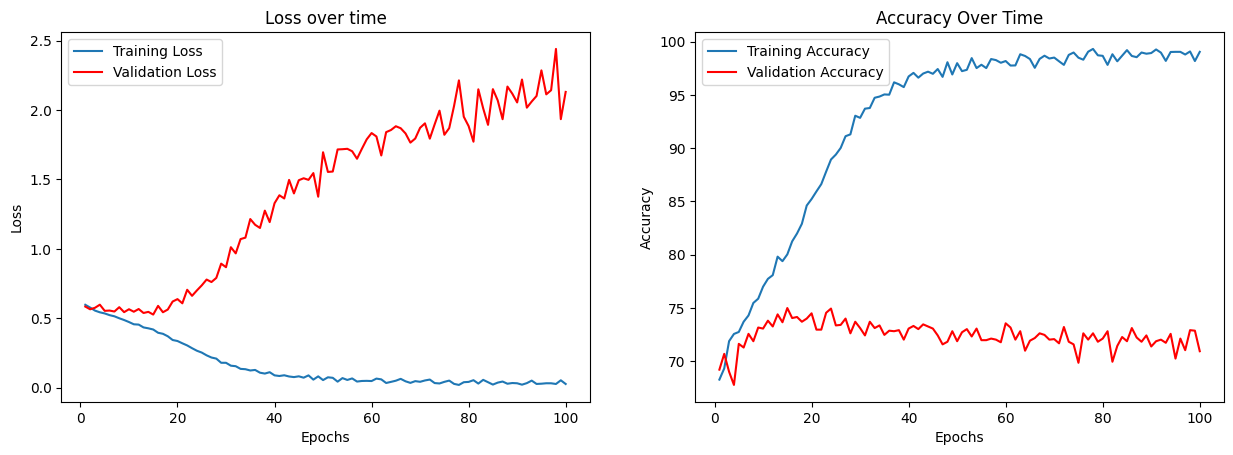

In [7]:
x_index = range(1, epochs+1, 1)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)

ax1.plot(x_index, training_loss, label="Training Loss")
ax1.plot(x_index, val_loss, color='red', label="Validation Loss")
ax1.set_title("Loss over time")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(x_index, training_acc, label="Training Accuracy")
ax2.plot(x_index, val_acc, color='red', label="Validation Accuracy")
ax2.legend()
ax2.set_title("Accuracy Over Time")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")

print(np.min(training_loss), np.argmin(training_loss, axis=0))
print(np.max(training_acc), np.argmax(training_acc, axis=0))
print(np.min(val_loss), np.argmin(val_loss, axis=0), val_acc[np.argmin(val_loss, axis=0)])

## Next Steps:

- Doing a manual calculation of mean and std-dev of all RGB channels (after resizing), running a model on all the new values. (DONE)
- No mean/std-dev, running a model
- Adding dropout (after one or both max-pooling layers) and early stopping
- More kernels
- Larger image
- Combined with all features known to help compared with base

In [6]:
# load the best train model for base
lenet_train_1 = LeNet()
lenet_train_1.load_state_dict(torch.load(best_model_train_path1))
lenet_train_1.to(device)

# load the best val model for base
lenet_val_1 = LeNet()
lenet_val_1.load_state_dict(torch.load(best_model_val_path1))
lenet_val_1.to(device)

success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data

        # Move tensors to GPU for doing model testing
        im = im.to(device)
        ground_truth = ground_truth.to(device)
        
        op = lenet_train_1(im)        
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print(f'Best Training Model accuracy on {len(testloader.dataset)} images from test dataset: %5.3f %%' % (100 * success / counter))

success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data

        # Move tensors to GPU for doing model testing
        im = im.to(device)
        ground_truth = ground_truth.to(device)
        
        op = lenet_val_1(im)        
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print(f'Best Validation Model accuracy on {len(testloader.dataset)} images from test dataset: %5.3f %%' % (100 * success / counter))

Best Training Model accuracy on 2023 images from test dataset: 72.615 %
Best Validation Model accuracy on 2023 images from test dataset: 74.988 %


In [7]:
class_success = list(0. for i in range(2))
class_counter = list(0. for i in range(2))

with torch.no_grad():
    for data in testloader:
        im, ground_truth = data

        # Move tensors to GPU for doing model testing
        im = im.to(device)
        
        op = lenet_train_1(im)
        _, pred = torch.max(op, 1)

        # Move tensors back to CPU
        pred = pred.cpu()
        im = im.cpu()
        ground_truth = ground_truth.cpu()
        
        c = (pred == ground_truth).squeeze()
        for i in range(2023):
            ground_truth_curr = ground_truth[i]
            class_success[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1

for i in range(2):
    print('Train Model accuracy for class %5s : %5.3f %%' % (classes[i], 100 * class_success[i] / class_counter[i]))

class_success = list(0. for i in range(2))
class_counter = list(0. for i in range(2))

with torch.no_grad():
    for data in testloader:
        im, ground_truth = data

        # Move tensors to GPU for doing model testing
        im = im.to(device)
        
        op = lenet_val_1(im)
        _, pred = torch.max(op, 1)

        # Move tensors back to CPU
        pred = pred.cpu()
        im = im.cpu()
        ground_truth = ground_truth.cpu()
        
        c = (pred == ground_truth).squeeze()
        for i in range(2023):
            ground_truth_curr = ground_truth[i]
            class_success[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1

for i in range(2):
    print('Validation Model accuracy for class %5s : %5.3f %%' % (classes[i], 100 * class_success[i] / class_counter[i]))

Train Model accuracy for class   cat : 72.799 %
Train Model accuracy for class   dog : 72.431 %
Validation Model accuracy for class   cat : 69.931 %
Validation Model accuracy for class   dog : 80.040 %


In [11]:
train_transform = transforms.Compose([transforms.Resize(size=(32,32), antialias=True),
                                      transforms.ToTensor()])

train_dataset = torchvision.datasets.ImageFolder(root="catdog/training_set", transform=train_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

def batch_mean_and_sd(loader):    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)        
    return mean,std

mean, std = batch_mean_and_sd(trainloader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.4882, 0.4551, 0.4174]) tensor([0.2441, 0.2371, 0.2398])


mean: ([0.4882, 0.4551, 0.4174]) std_dev: ([0.2441, 0.2371, 0.2398])


In [8]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.Resize(size=(32,32), antialias=True),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.488, 0.455, 0.417), (0.244, 0.237, 0.240))])

train_dataset = torchvision.datasets.ImageFolder(root="catdog/training_set", transform=train_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_transform = transforms.Compose([transforms.Resize(size=(32,32), antialias=True), transforms.ToTensor(), transforms.Normalize((0.488, 0.455, 0.417), (0.244, 0.237, 0.240))])

test_dataset = torchvision.datasets.ImageFolder(root="catdog/test_set", transform=test_transform)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [9]:
# paths to save the best model on training, and the best model on validation
best_model_train_path2 = './best_train_model_meancalculated.pth'
best_model_val_path2 = './best_val_model_meancalculated.pth'

In [27]:
lenet_modified = LeNet()
lenet_modified.to(device)
print(lenet_modified)

# define optimizer
optim = torch.optim.Adam(lenet_modified.parameters(), lr=0.001)

training_loss_mod1 = []
training_acc_mod1 = []
val_loss_mod1 = []
val_acc_mod1 = []
epochs = 100

best_train_loss = 0.0
best_val_loss = 0.0

# training loop over the dataset multiple times
for epoch in range(epochs):  
    t_loss, t_acc = train(lenet_modified, trainloader, optim, epoch)        
    training_loss_mod1.append(t_loss)
    training_acc_mod1.append(t_acc)
    print() # Newline
    v_loss, v_acc = test(lenet_modified, testloader)
    val_loss_mod1.append(v_loss)
    val_acc_mod1.append(v_acc)
    print()
    if best_train_loss > t_loss or best_train_loss <= 0:
        print("Better training loss, saving model.")
        best_train_loss = t_loss
        torch.save(lenet_modified.state_dict(), best_model_train_path2)
    if best_val_loss > v_loss or best_val_loss <= 0:
        print("Better validation loss, saving model.")
        best_val_loss = v_loss
        torch.save(lenet_modified.state_dict(), best_model_val_path2)

# Save model for future use
model_path = './base_model_meancalculated_100_epoch.pth'
torch.save(lenet_modified.state_dict(), model_path)

print('Finished Training')

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[Epoch number : 1] accuracy: 54.279, loss: 0.750

LeNet accuracy on 2023 images from test dataset: 52.59515570934256. Loss: 0.702424168586731

Better training loss, saving model.
Better validation loss, saving model.
[Epoch number : 2] accuracy: 61.949, loss: 0.649

LeNet accuracy on 2023 images from test dataset: 64.45872466633712. Loss: 0.6333167552947998

Better training loss, saving model.
Better validation loss, saving model.
[Epoch number : 3] accuracy: 65.6

0.02000767342446871 88
99.32542161149281 88
0.5276114344596863 11 74.14730598121602


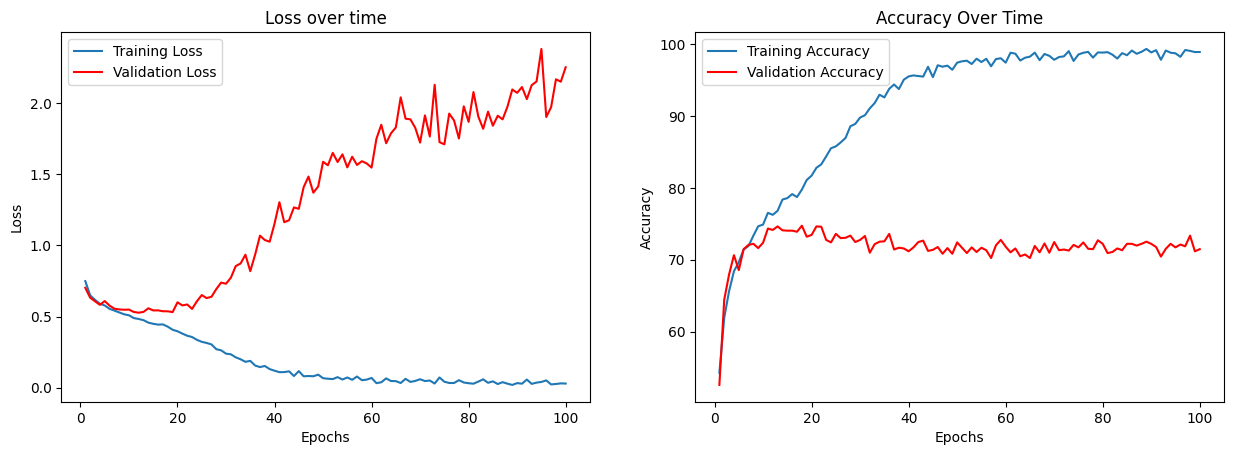

In [28]:
x_index = range(1, epochs+1, 1)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)

ax1.plot(x_index, training_loss_mod1, label="Training Loss")
ax1.plot(x_index, val_loss_mod1, color='red', label="Validation Loss")
ax1.set_title("Loss over time")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(x_index, training_acc_mod1, label="Training Accuracy")
ax2.plot(x_index, val_acc_mod1, color='red', label="Validation Accuracy")
ax2.legend()
ax2.set_title("Accuracy Over Time")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")

print(np.min(training_loss_mod1), np.argmin(training_loss_mod1, axis=0))
print(np.max(training_acc_mod1), np.argmax(training_acc_mod1, axis=0))
print(np.min(val_loss_mod1), np.argmin(val_loss_mod1, axis=0), val_acc_mod1[np.argmin(val_loss_mod1, axis=0)])

In [10]:
# load the best train model for base
lenet_train_2 = LeNet()
lenet_train_2.load_state_dict(torch.load(best_model_train_path2))
lenet_train_2.to(device)

# load the best val model for base
lenet_val_2 = LeNet()
lenet_val_2.load_state_dict(torch.load(best_model_val_path2))
lenet_val_2.to(device)

success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data

        # Move tensors to GPU for doing model testing
        im = im.to(device)
        ground_truth = ground_truth.to(device)
        
        op = lenet_train_2(im)        
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print(f'Train Model accuracy on {len(testloader.dataset)} images from test dataset: %5.3f %%' % (100 * success / counter))

success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data

        # Move tensors to GPU for doing model testing
        im = im.to(device)
        ground_truth = ground_truth.to(device)
        
        op = lenet_val_2(im)        
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print(f'Validation Model accuracy on {len(testloader.dataset)} images from test dataset: %5.3f %%' % (100 * success / counter))

Train Model accuracy on 2023 images from test dataset: 72.516 %
Validation Model accuracy on 2023 images from test dataset: 74.147 %


In [11]:
class_success = list(0. for i in range(2))
class_counter = list(0. for i in range(2))

with torch.no_grad():
    for data in testloader:
        im, ground_truth = data

        # Move tensors to GPU for doing model testing
        im = im.to(device)
        
        op = lenet_train_2(im)
        _, pred = torch.max(op, 1)

        # Move tensors back to CPU
        pred = pred.cpu()
        im = im.cpu()
        ground_truth = ground_truth.cpu()
        
        c = (pred == ground_truth).squeeze()
        for i in range(2023):
            ground_truth_curr = ground_truth[i]
            class_success[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1

for i in range(2):
    print('Train Model accuracy for class %5s : %5.3f %%' % (classes[i], 100 * class_success[i] / class_counter[i]))

class_success = list(0. for i in range(2))
class_counter = list(0. for i in range(2))

with torch.no_grad():
    for data in testloader:
        im, ground_truth = data

        # Move tensors to GPU for doing model testing
        im = im.to(device)
        
        op = lenet_val_2(im)
        _, pred = torch.max(op, 1)

        # Move tensors back to CPU
        pred = pred.cpu()
        im = im.cpu()
        ground_truth = ground_truth.cpu()
        
        c = (pred == ground_truth).squeeze()
        for i in range(2023):
            ground_truth_curr = ground_truth[i]
            class_success[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1

for i in range(2):
    print('Validation Model accuracy for class %5s : %5.3f %%' % (classes[i], 100 * class_success[i] / class_counter[i]))

Train Model accuracy for class   cat : 77.448 %
Train Model accuracy for class   dog : 67.589 %
Validation Model accuracy for class   cat : 81.108 %
Validation Model accuracy for class   dog : 67.194 %


In [12]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.Resize(size=(32,32), antialias=True),
                                      transforms.ToTensor()])

train_dataset = torchvision.datasets.ImageFolder(root="catdog/training_set", transform=train_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_transform = transforms.Compose([transforms.Resize(size=(32,32), antialias=True), transforms.ToTensor()])

test_dataset = torchvision.datasets.ImageFolder(root="catdog/test_set", transform=test_transform)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

classes = ('cat', 'dog')

In [13]:
# paths to save the best model on training, and the best model on validation
best_model_train_path3 = './best_train_model_nomean.pth'
best_model_val_path3 = './best_val_model_nomean.pth'

In [19]:
lenet_no_mean = LeNet()
lenet_no_mean.to(device)
print(lenet_no_mean)

# define optimizer
optim = torch.optim.Adam(lenet_no_mean.parameters(), lr=0.001)

training_loss_mod3 = []
training_acc_mod3 = []
val_loss_mod3 = []
val_acc_mod3 = []
epochs = 100

best_train_loss = 0.0
best_val_loss = 0.0

# training loop over the dataset multiple times
for epoch in range(epochs):  
    t_loss, t_acc = train(lenet_no_mean, trainloader, optim, epoch)        
    training_loss_mod3.append(t_loss)
    training_acc_mod3.append(t_acc)
    print() # Newline
    v_loss, v_acc = test(lenet_no_mean, testloader)
    val_loss_mod3.append(v_loss)
    val_acc_mod3.append(v_acc)
    print()
    if best_train_loss > t_loss or best_train_loss <= 0:
        print("Better training loss, saving model.")
        best_train_loss = t_loss
        torch.save(lenet_no_mean.state_dict(), best_model_train_path3)
    if best_val_loss > v_loss or best_val_loss <= 0:
        print("Better validation loss, saving model.")
        best_val_loss = v_loss
        torch.save(lenet_no_mean.state_dict(), best_model_val_path3)

# Save model for future use
model_path = './base_model_nomean_100_epoch.pth'
torch.save(lenet_no_mean.state_dict(), model_path)

print('Finished Training')

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[Epoch number : 1] accuracy: 50.181, loss: 0.765

LeNet accuracy on 2023 images from test dataset: 52.44686109738013. Loss: 0.6939983367919922

Better training loss, saving model.
Better validation loss, saving model.
[Epoch number : 2] accuracy: 53.779, loss: 0.690

LeNet accuracy on 2023 images from test dataset: 60.55363321799308. Loss: 0.6755697727203369

Better training loss, saving model.
Better validation loss, saving model.
[Epoch number : 3] accuracy: 58.

0.03923381217279632 98
98.63835103060588 98
0.5322265028953552 19 74.34503213049926


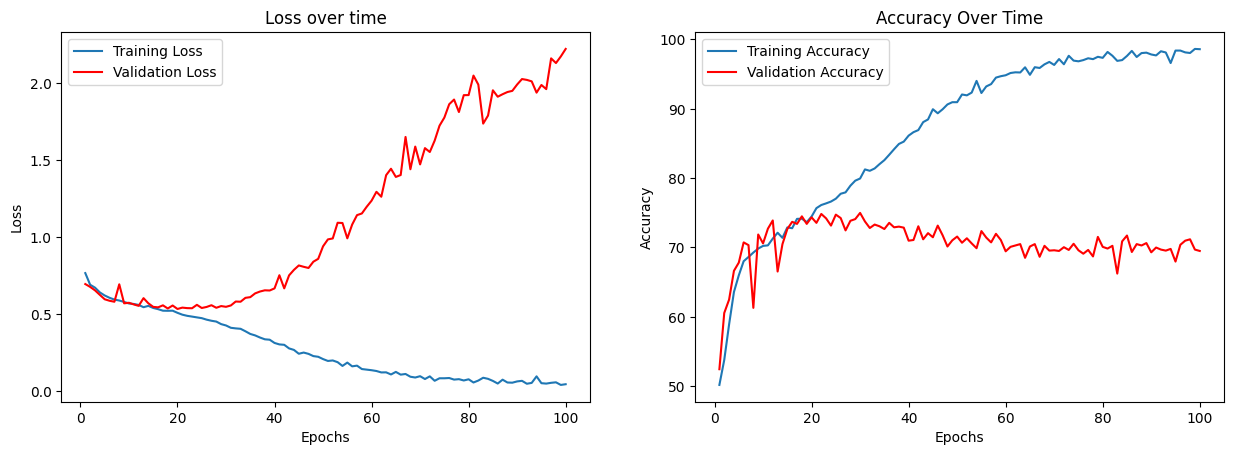

In [20]:
x_index = range(1, epochs+1, 1)

fig, (ax1, ax2) = plt.subplots(1, 2)cyberpunk
fig.set_figwidth(15)

ax1.plot(x_index, training_loss_mod3, label="Training Loss")
ax1.plot(x_index, val_loss_mod3, color='red', label="Validation Loss")
ax1.set_title("Loss over time")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(x_index, training_acc_mod3, label="Training Accuracy")
ax2.plot(x_index, val_acc_mod3, color='red', label="Validation Accuracy")
ax2.legend()
ax2.set_title("Accuracy Over Time")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")

print(np.min(training_loss_mod3), np.argmin(training_loss_mod3, axis=0))
print(np.max(training_acc_mod3), np.argmax(training_acc_mod3, axis=0))
print(np.min(val_loss_mod3), np.argmin(val_loss_mod3, axis=0), val_acc_mod3[np.argmin(val_loss_mod3, axis=0)])

In [23]:
# load the best train model for base
lenet_train_3 = LeNet()
lenet_train_3.load_state_dict(torch.load(best_model_train_path3))
lenet_train_3.to(device)

# load the best val model for base
lenet_val_3 = LeNet()
lenet_val_3.load_state_dict(torch.load(best_model_val_path3))
lenet_val_3.to(device)

success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data

        # Move tensors to GPU for doing model testing
        im = im.to(device)
        ground_truth = ground_truth.to(device)
        
        op = lenet_train_3(im)        
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print(f'Train Model accuracy on {len(testloader.dataset)} images from test dataset: %5.3f %%' % (100 * success / counter))

success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data

        # Move tensors to GPU for doing model testing
        im = im.to(device)
        ground_truth = ground_truth.to(device)
        
        op = lenet_val_3(im)        
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print(f'Validation Model accuracy on {len(testloader.dataset)} images from test dataset: %5.3f %%' % (100 * success / counter))

Train Model accuracy on 2023 images from test dataset: 69.698 %
Validation Model accuracy on 2023 images from test dataset: 74.345 %


In [24]:
class_success = list(0. for i in range(2))
class_counter = list(0. for i in range(2))

with torch.no_grad():
    for data in testloader:
        im, ground_truth = data

        # Move tensors to GPU for doing model testing
        im = im.to(device)
        
        op = lenet_train_3(im)
        _, pred = torch.max(op, 1)

        # Move tensors back to CPU
        pred = pred.cpu()
        im = im.cpu()
        ground_truth = ground_truth.cpu()
        
        c = (pred == ground_truth).squeeze()
        for i in range(2023):
            ground_truth_curr = ground_truth[i]
            class_success[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1

for i in range(2):
    print('Train Model accuracy for class %5s : %5.3f %%' % (classes[i], 100 * class_success[i] / class_counter[i]))

class_success = list(0. for i in range(2))
class_counter = list(0. for i in range(2))

with torch.no_grad():
    for data in testloader:
        im, ground_truth = data

        # Move tensors to GPU for doing model testing
        im = im.to(device)
        
        op = lenet_val_3(im)
        _, pred = torch.max(op, 1)

        # Move tensors back to CPU
        pred = pred.cpu()
        im = im.cpu()
        ground_truth = ground_truth.cpu()
        
        c = (pred == ground_truth).squeeze()
        for i in range(2023):
            ground_truth_curr = ground_truth[i]
            class_success[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1

for i in range(2):
    print('Validation Model accuracy for class %5s : %5.3f %%' % (classes[i], 100 * class_success[i] / class_counter[i]))

Train Model accuracy for class   cat : 70.326 %
Train Model accuracy for class   dog : 69.071 %
Validation Model accuracy for class   cat : 76.954 %
Validation Model accuracy for class   dog : 71.739 %
